### An example of the SIGW inverse problem with the full numerical integration 

In [19]:
import sys
sys.path.append('../')
from jax import vmap, jit, grad, random, jacfwd
from jax.lax import map
import jax.numpy as jnp
import numpy as np
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import warnings
from jax import config
config.update("jax_enable_x64", True)
import numpyro
from interpolation.omega_gw_jax import OmegaGWjax
from interpolation.model import fixed_nodes_model, spline_predict, variable_nodes_model
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=4,suppress=True)
jnp.set_printoptions(precision=4,suppress=True)
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


#### A simple test curvature power spectrum and $\Omega_{\rm GW}$

(40,)


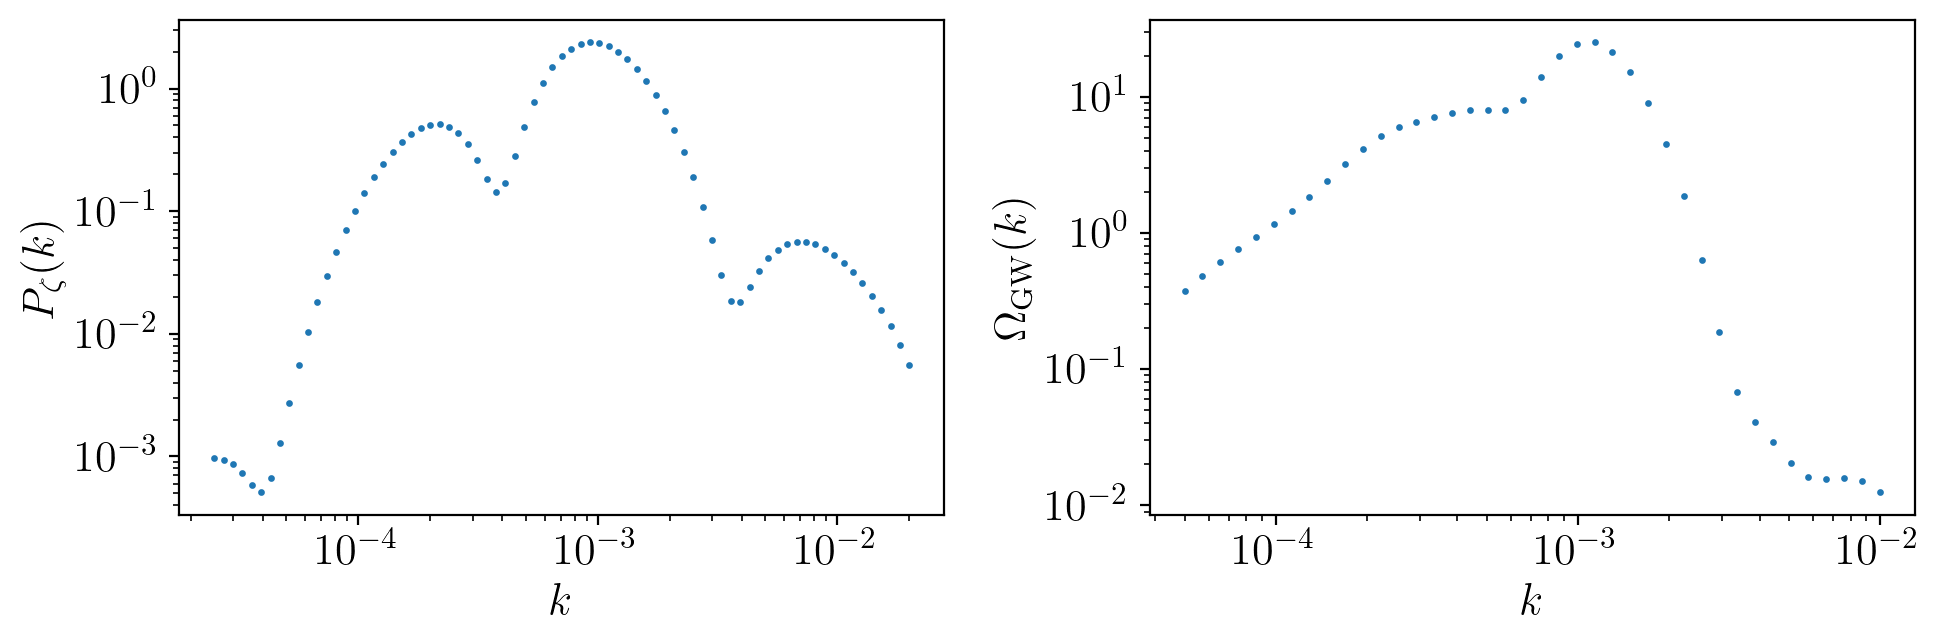

In [20]:
# set up the power spectrum and omgw
psize = 75
ksize = 40
p_arr = jnp.geomspace(2.5e-5,2e-2,psize)
k_arr = jnp.geomspace(5e-5,1e-2,ksize)

f = k_arr #jnp.geomspace(5e-5, 1e-2, ksize)  # The frequencies to calculate Omega_GW
s = jnp.linspace(0, 1, 15)  # First rescaled internal momentum
t = jnp.logspace(-3,4, 100)  # Second rescaled internal momentum

## Expand t to add a new axis
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(f), axis=-1)

@jit
def pz(p,pstar=5e-4,n1=3,n2=-2,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    osc = (1 + 16.4*jnp.cos(1.4*jnp.log(p/1.))**2)
    return pl1 * pl2 *osc

omgw_calculator =  OmegaGWjax(s, t, f=f, kernel="RD", upsample=False)


pz_amp = pz(p_arr)
omgw_amp = omgw_calculator(pz,f)

print(omgw_amp.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.scatter(p_arr,pz_amp,s=2)
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.scatter(f,omgw_amp,s=2)
for ax in [ax1,ax2]:
    ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout();

#### Let's set up the inference with an uncertainity on the GWB

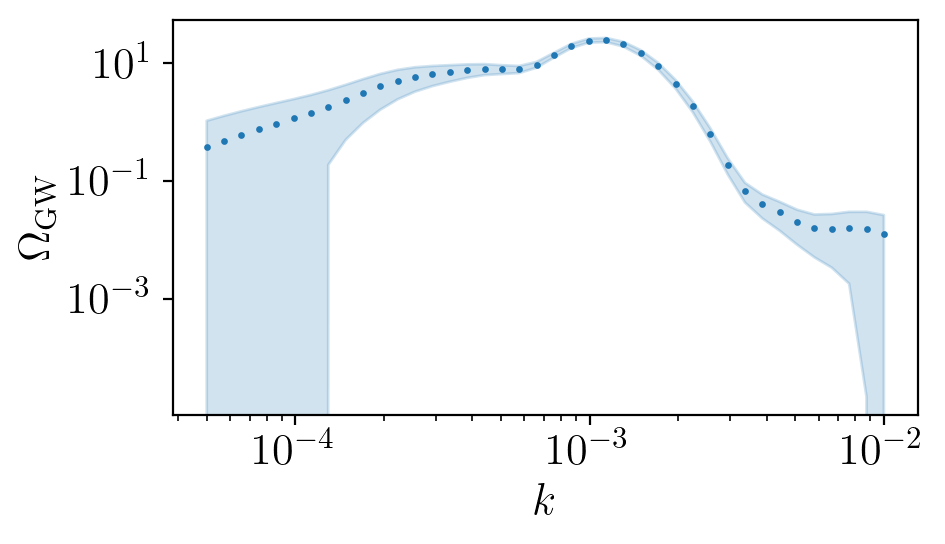

In [21]:
kstar = 1e-3
omks_sigma = omgw_amp*( 0.1*(np.log(k_arr/kstar))**2 + 0.04) # 4% error at kstar + more towards edges
omgw_cov = jnp.diag(omks_sigma**2)
fig,ax = plt.subplots(1,1,figsize=(5,3.))
ax.set_ylabel(r'$\Omega_{\mathrm{GW}}$')
ax.scatter(k_arr,omgw_amp,s=2)
ax.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout()

In [22]:
# Set up the fixed node interpolator
kmin, kmax = min(p_arr), max(p_arr)
omgw_method_kwargs = {'s': s, 't': t}
nbins = 12
pz_model = fixed_nodes_model(nbins=nbins,pz_kmin=kmin,pz_kmax=kmax,
                            omgw_karr=k_arr,omgw_means=omgw_amp,
                            omgw_cov=omgw_cov,omgw_method='jax',omgw_method_kwargs=omgw_method_kwargs,y_low=-5,y_high=1)

In [23]:
# run the HMC
samples, _ = pz_model.run_hmc_inference(num_warmup=512,num_samples=512)

sample: 100%|██████████| 1024/1024 [01:45<00:00,  9.66it/s, 18 steps of size 1.04e-01. acc. prob=0.75]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      y[0]     -2.84      3.32     -2.11     -7.80      1.98     57.69      1.00
      y[1]     -7.13      2.45     -7.14    -11.47     -3.61     58.54      1.01
      y[2]     -4.90      2.55     -4.73     -9.36     -1.30     25.19      1.18
      y[3]     -3.80      3.23     -2.91     -9.06     -0.04     18.99      1.14
      y[4]     -3.64      1.25     -3.38     -5.40     -1.90     19.74      1.10
      y[5]     -0.37      0.09     -0.35     -0.54     -0.25     36.61      1.01
      y[6]      0.85      0.03      0.85      0.81      0.90     47.02      1.00
      y[7]     -0.16      0.05     -0.16     -0.24     -0.08     39.86      1.00
      y[8]     -3.03      0.10     -3.02     -3.19     -2.85     56.91      1.00
      y[9]     -5.03      0.97     -4.93     -6.23     -3.39     19.23      1.23
     y[10]     -5.11      1.95     -4.55     -8.18     -2.80      8.51      1.36
     y[11]     -0.96      0

#### Now we plot some realisations of the inferred $P_{\zeta}$ from the MCMC samples

(4, 75)


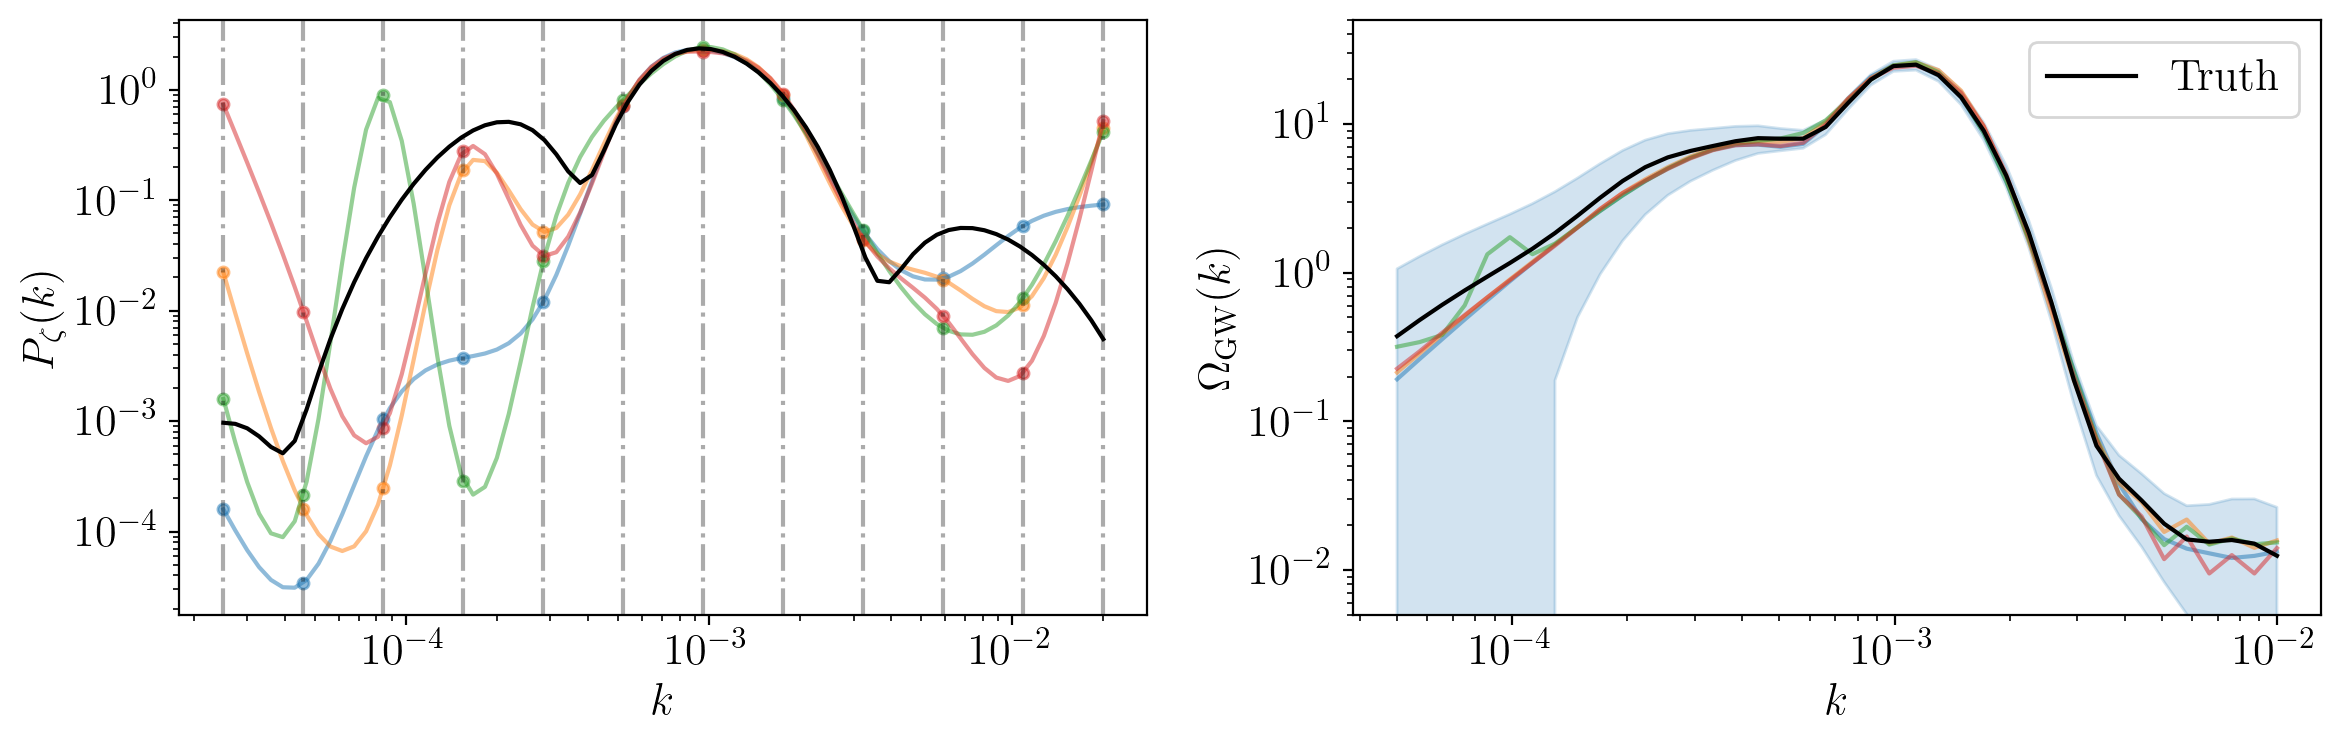

In [24]:
nodes = pz_model.log_k_nodes
ys = samples['y'][::128] #jnp.median(samples['y'])
ff = lambda y: spline_predict(x_train=nodes,y_train=y,x_pred=f)

def omega_f(y):
    res = pz_model.get_omgw_from_y(y=y)
    return res
omgw_amps = map(omega_f,ys)

ff = lambda y: spline_predict(x_train=nodes,y_train=y,x_pred=p_arr)
pz_amps = vmap(ff,)(ys)
print(pz_amps.shape)
# omgw_amps = jnp.einsum("pi,pj,kij->pk",pz_amps,pz_amps,omgw_calculator.omkij)
# print(omgw_amps.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

for i,pz in enumerate(pz_amps):
    ax1.loglog(p_arr,pz,alpha=0.5)
    ax1.scatter(jnp.exp(nodes),jnp.exp(ys[i]),s=16,alpha=0.5)
for om in omgw_amps:
    ax2.loglog(k_arr,om,alpha=0.5)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.plot(k_arr,omgw_amp,color='k',lw=1.5,label='Truth')
ax2.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set(yscale='log',xscale='log')

ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.set_ylim(5e-3,5e1)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
ax2.legend()
for val in nodes:
    ax1.axvline(jnp.exp(val),color='k',ls='-.',alpha=0.33)
fig.tight_layout()

# the dashed lines represent the spline node locations

#### Do an optimization instead of HMC sampling

In [25]:
from interpolation.model import optim_scipy_bh , optim_optax
nodes = pz_model.log_k_nodes
best_params, _ = optim_scipy_bh(x0 = -3*jnp.ones(nbins),loss = pz_model.loss,bounds=(-8,2),stepsize=0.2,niter=20) 
# best_params, _ =  optim_optax(x0 = -2*jnp.ones(nbins), loss = pz_model.loss, start_learning_rate=0.3 , steps = 200, jump_sdev=1.,y_low=-8.,y_high=1.)
print(best_params)
pz_bf = lambda x: spline_predict(x_train=nodes,y_train=best_params,x_pred=x)
# omgw_calculator =  OmegaGWjax(s, t, f=f, kernel="RD", upsample=False)
omgw_bf = pz_model.get_omgw_from_y(y=best_params) #omgw_calculator(pz_bf,f) #jnp.einsum("i,j,kij->k",pz_bf,pz_bf,omgw_calculator.omkij)

[-3.1287 -2.1545 -2.454  -1.9006 -3.453  -0.3618  0.8356 -0.1512 -3.0487
 -3.2803 -3.1348 -3.6467]


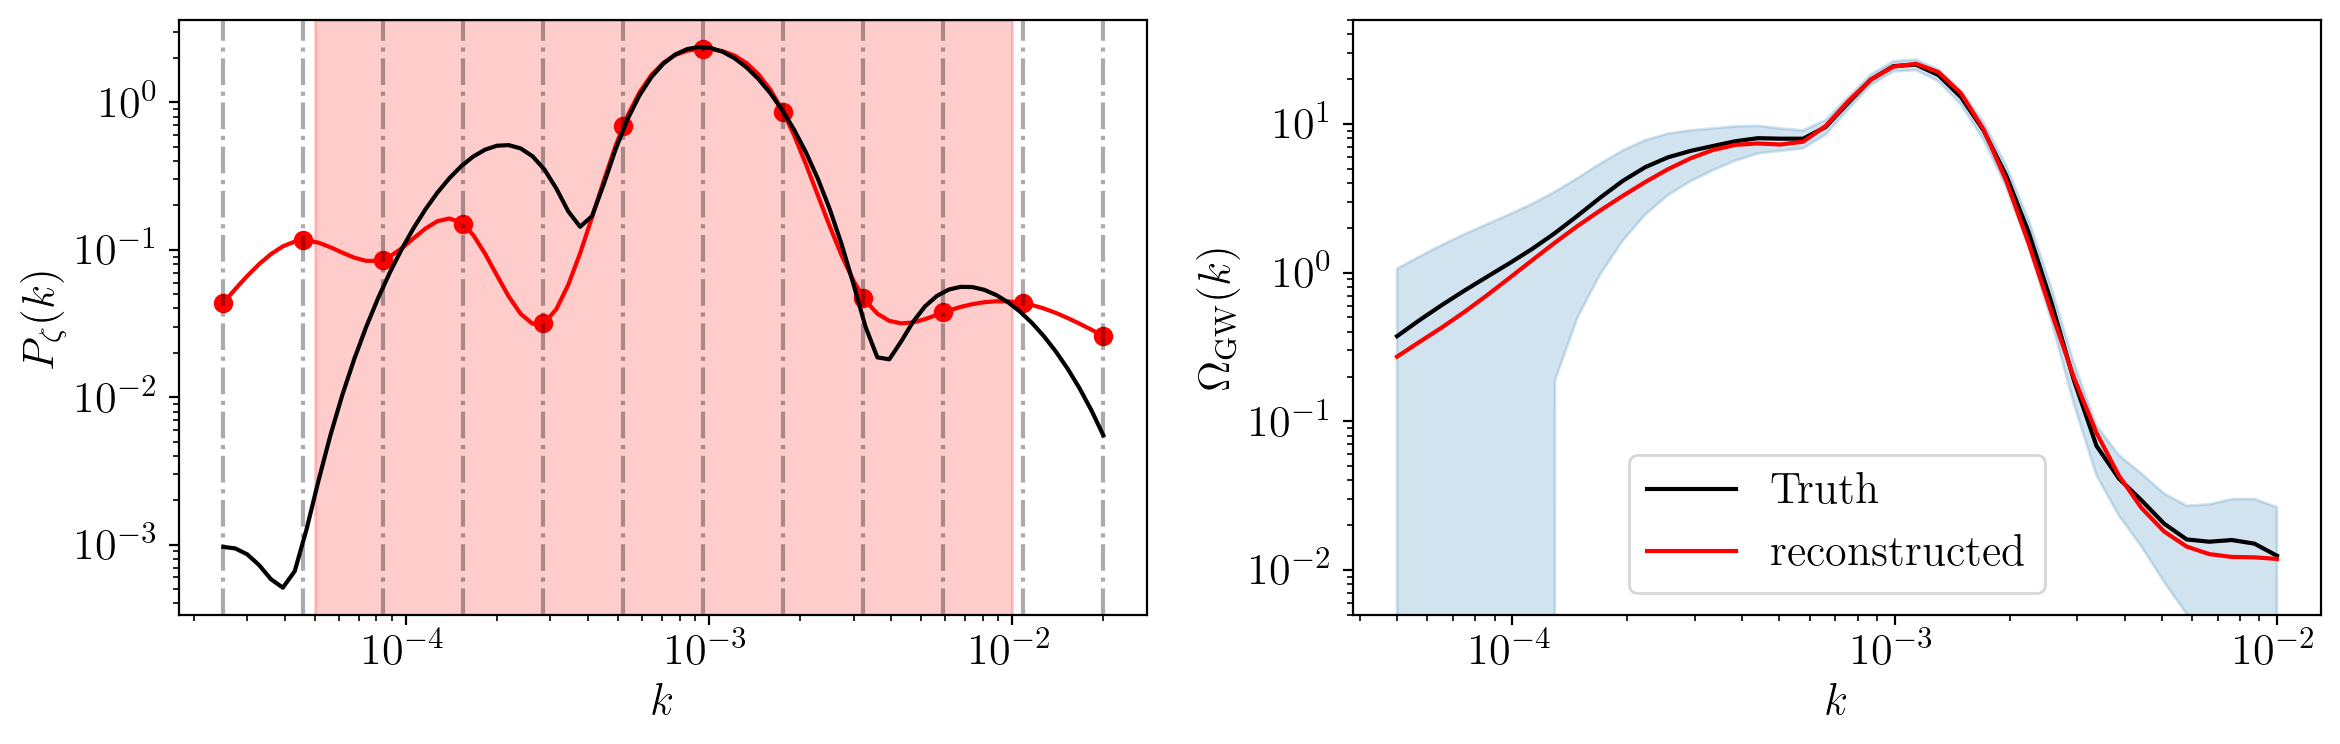

In [26]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.loglog(p_arr,pz_bf(p_arr),color='r')
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.plot(k_arr,omgw_amp,color='k',lw=1.5,label='Truth')
ax2.loglog(k_arr,omgw_bf,color='r',label='reconstructed')
ax2.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set(yscale='log',xscale='log')

ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.set_ylim(5e-3,5e1)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
ax2.legend()
for val in nodes:
    ax1.axvline(jnp.exp(val),color='k',ls='-.',alpha=0.33)
ax1.axvspan(f[0],f[-1],alpha=0.2,color='r')
ax1.scatter(jnp.exp(nodes),jnp.exp(best_params),color='r')
fig.tight_layout()


#### Now testing with a variable number of nodes

In [27]:
kmin, kmax = min(p_arr), max(p_arr)
omgw_method_kwargs = {'s': s, 't': t}
nbins = 10
pz_model = variable_nodes_model(nbins=nbins,pz_kmin=kmin,pz_kmax=kmax,
                            omgw_karr=k_arr,omgw_means=omgw_amp,
                            omgw_cov=omgw_cov,omgw_method='jax',omgw_method_kwargs=omgw_method_kwargs,y_low=-5,y_high=1)

[-10.5298  -9.7109  -8.8921  -8.0732  -7.2543  -6.4355  -5.6166  -4.7977] [-9.7109 -8.8921 -8.0732 -7.2543 -6.4355 -5.6166 -4.7977 -3.9789]


In [28]:
# run the HMC
samples, _ = pz_model.run_hmc_inference(num_warmup=512,num_samples=512)

sample: 100%|██████████| 1024/1024 [10:20<00:00,  1.65it/s, 47 steps of size 1.03e-02. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      x[0]    -10.60      0.00    -10.60    -10.60    -10.60      0.50      1.00
      x[1]    -10.14      0.23    -10.13    -10.50     -9.82     33.07      1.02
      x[2]     -9.36      0.22     -9.38     -9.71     -9.05     10.10      1.16
      x[3]     -8.43      0.26     -8.45     -8.79     -8.07      5.44      1.07
      x[4]     -7.85      0.16     -7.90     -8.06     -7.60     12.98      1.12
      x[5]     -6.85      0.18     -6.80     -7.12     -6.60      4.46      1.52
      x[6]     -6.07      0.20     -6.09     -6.32     -5.69      7.85      1.20
      x[7]     -5.36      0.22     -5.42     -5.62     -5.03      9.48      1.00
      x[8]     -4.45      0.21     -4.48     -4.80     -4.15     23.14      1.10
      x[9]     -3.91      0.00     -3.91     -3.91     -3.91      0.50      1.00
 x_bins[0]    -10.14      0.23    -10.13    -10.50     -9.82     33.07      1.02
 x_bins[1]     -9.36      0

(8, 75)


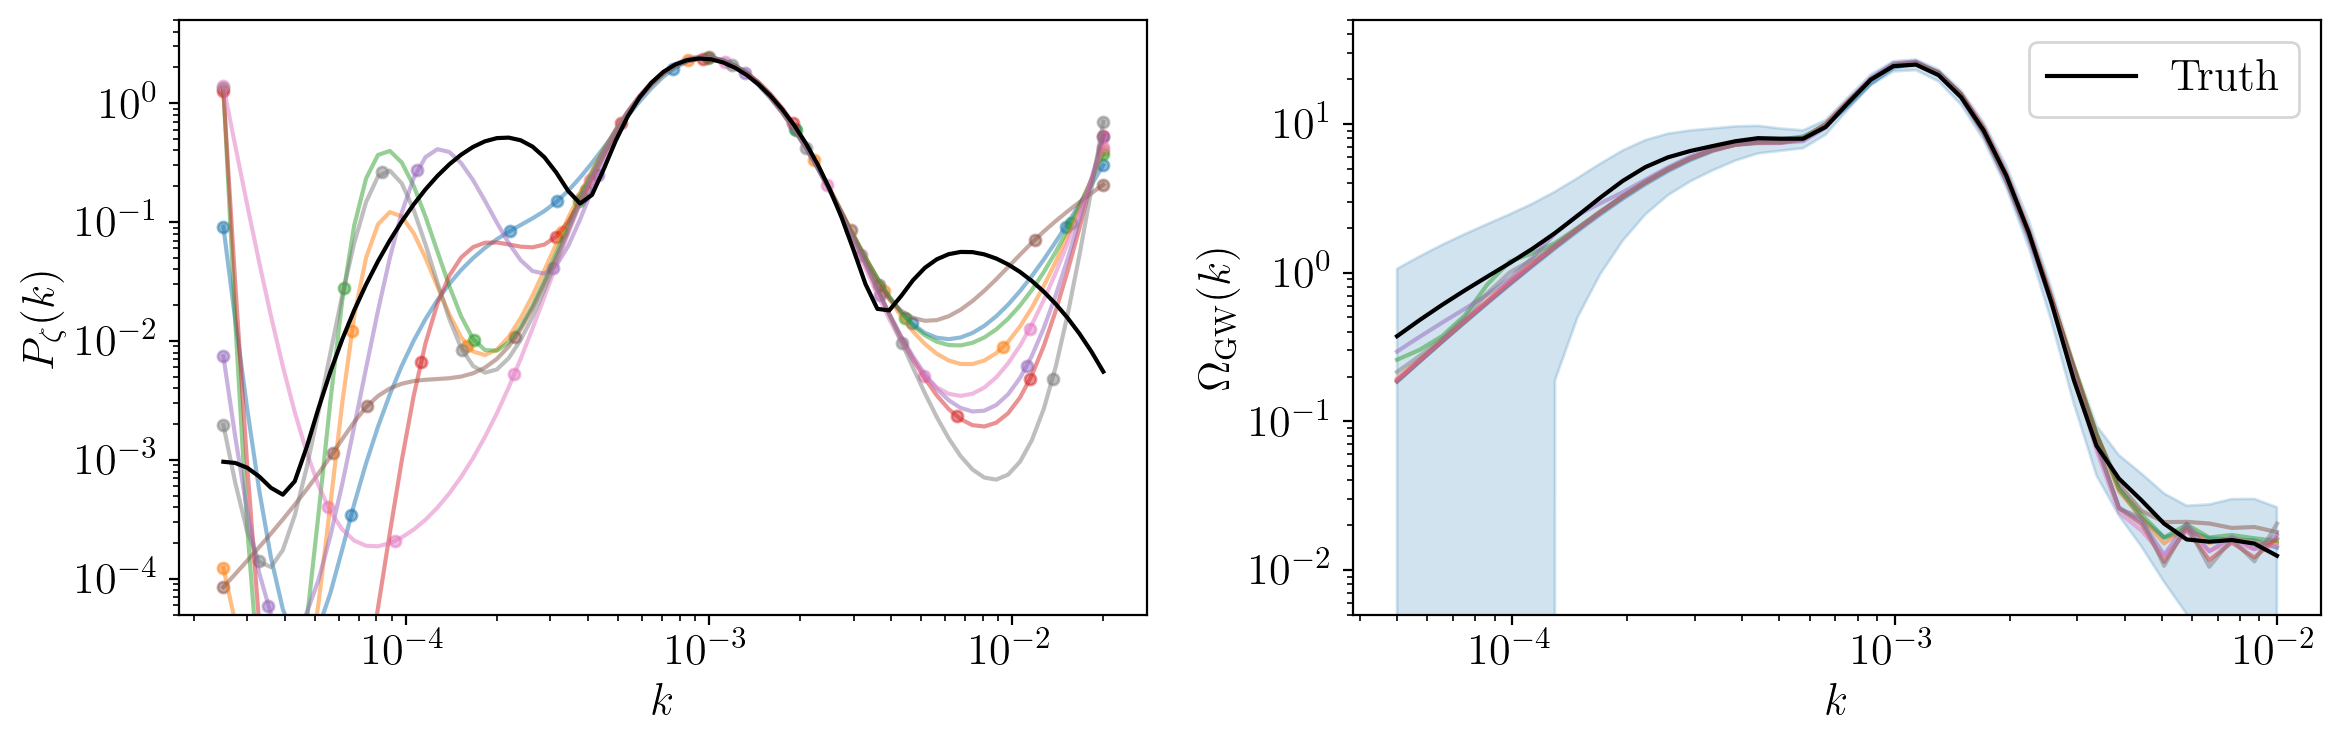

In [29]:
nodes = pz_model.log_k_nodes
ys = samples['y'][::64] #jnp.median(samples['y'])
xs = samples['x'][::64]
ff = lambda y: spline_predict(x_train=nodes,y_train=y,x_pred=f)

def omega_f(x,y):
    res = pz_model.get_omgw_from_xy(x=x,y=y)
    return res
omgw_amps = vmap(omega_f,)(xs,ys)

ff = lambda x,y: spline_predict(x_train=x,y_train=y,x_pred=p_arr)
pz_amps = vmap(ff,)(xs,ys)
print(pz_amps.shape)
# omgw_amps = jnp.einsum("pi,pj,kij->pk",pz_amps,pz_amps,omgw_calculator.omkij)
# print(omgw_amps.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

for i,pz in enumerate(pz_amps):
    ax1.loglog(p_arr,pz,alpha=0.5)
    ax1.scatter(jnp.exp(xs[i]),jnp.exp(ys[i]),s=16,alpha=0.5)
for om in omgw_amps:
    ax2.loglog(k_arr,om,alpha=0.5)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.plot(k_arr,omgw_amp,color='k',lw=1.5,label='Truth')
ax2.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set(yscale='log',xscale='log')

ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.set_ylim(5e-3,5e1)
ax1.set_ylim(5e-5,5.)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
ax2.legend()
# for val in nodes:
#     ax1.axvline(jnp.exp(val),color='k',ls='-.',alpha=0.33)
fig.tight_layout()

# the dashed lines represent the spline node locations

In [30]:
from interpolation.model import optim_scipy_bh , optim_optax
nodes = pz_model.log_k_nodes
x0 = jnp.concatenate([jnp.geomspace(kmin,kmax,nbins-2),-3*jnp.ones(nbins)])
best_params, _ = optim_scipy_bh(x0 = x0,loss = pz_model.loss,bounds=(-8,2),stepsize=0.2,niter=20) 
# best_params, _ =  optim_optax(x0 = -2*jnp.ones(nbins), loss = pz_model.loss, start_learning_rate=0.3 , steps = 200, jump_sdev=1.,y_low=-8.,y_high=1.)
print(best_params)
x_best = jnp.concatenate([jnp.array([pz_model.lnk_min]),jnp.array(best_params[:nbins-2]),jnp.array([pz_model.lnk_max])])
pz_bf = lambda k: pz_model.spline(x=x_best,y=best_params[nbins-2:],k=k)
# omgw_calculator =  OmegaGWjax(s, t, f=f, kernel="RD", upsample=False)
omgw_bf = pz_model.get_omgw_from_xy(x = x_best,y=best_params[nbins-2:]) #omgw_calculator(pz_bf,f) #jnp.einsum("i,j,kij->k",pz_bf,pz_bf,omgw_calculator.omkij)

[ 0.1174  0.3113  0.1605  0.1057 -0.0292 -0.2244  0.0776 -0.3091 -3.3136
 -2.6197 -3.0815 -2.9288 -3.2808 -3.1185 -2.5914 -2.7987 -3.1391 -3.1386]


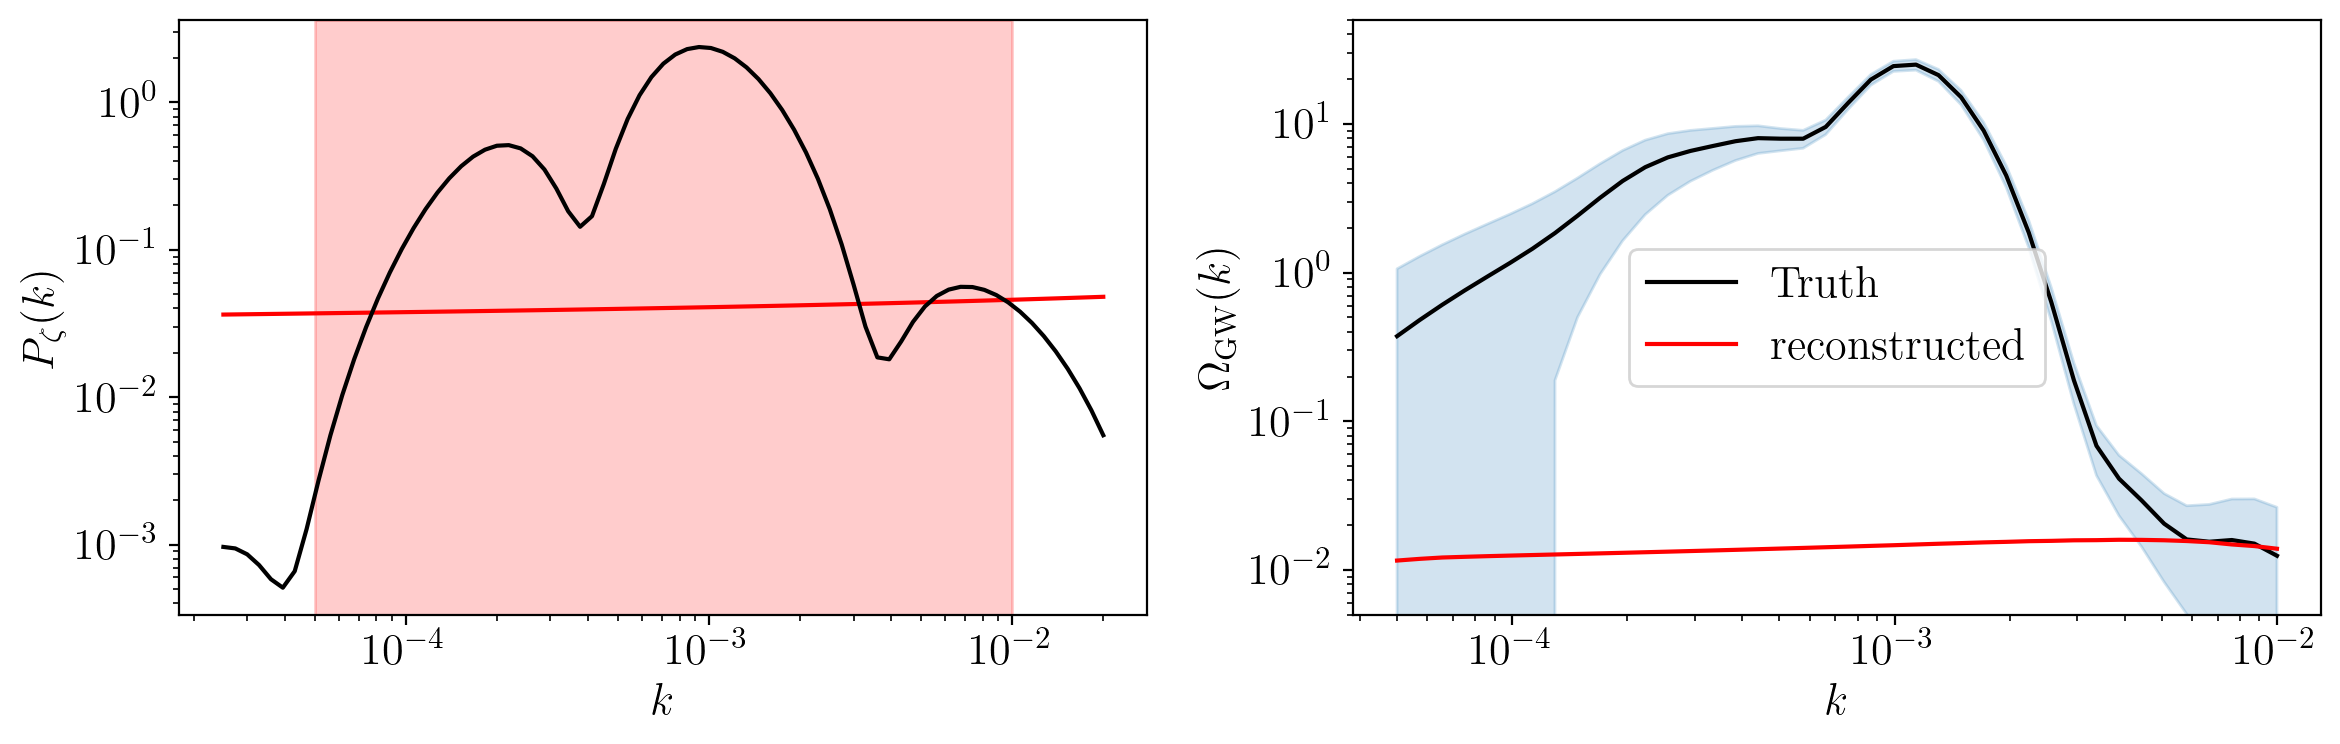

In [31]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.loglog(p_arr,pz_bf(p_arr),color='r')
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.plot(k_arr,omgw_amp,color='k',lw=1.5,label='Truth')
ax2.loglog(k_arr,omgw_bf,color='r',label='reconstructed')
ax2.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set(yscale='log',xscale='log')

ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.set_ylim(5e-3,5e1)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
ax2.legend()
# for val in nodes:
#     ax1.axvline(jnp.exp(val),color='k',ls='-.',alpha=0.33)
ax1.axvspan(f[0],f[-1],alpha=0.2,color='r')
# ax1.scatter(jnp.exp(nodes),jnp.exp(best_params),color='r')
fig.tight_layout()
